### Mandelbrot Set Visualisation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import qmc
import statistics
import time


In [3]:
def mandelbrot(c, z):
    return z**2 + c

def stability(c, max_iter):
    z = 0
    for i in range(max_iter):
        z = mandelbrot(c, z)
        if abs(z) > 2:
            return i
    return max_iter

def mandelbrot_set(width, height, real_range, imag_range, max_iter = 200):
    real_vals = np.linspace(real_range[0], real_range[1], width)
    imag_vals = np.linspace(imag_range[0], imag_range[1], height)
    
    image = np.empty((width, height))
    for i in range(width):
        for j in range(height):
            image[i, j] = stability(real_vals[i] + 1j*imag_vals[j], max_iter)
    return image
    

In [4]:
# Compute the Mandelbrot set
resolution = 1000
max_iter = 200
width = resolution
height = resolution
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
image = mandelbrot_set(width, height, real_range, imag_range, max_iter=max_iter)

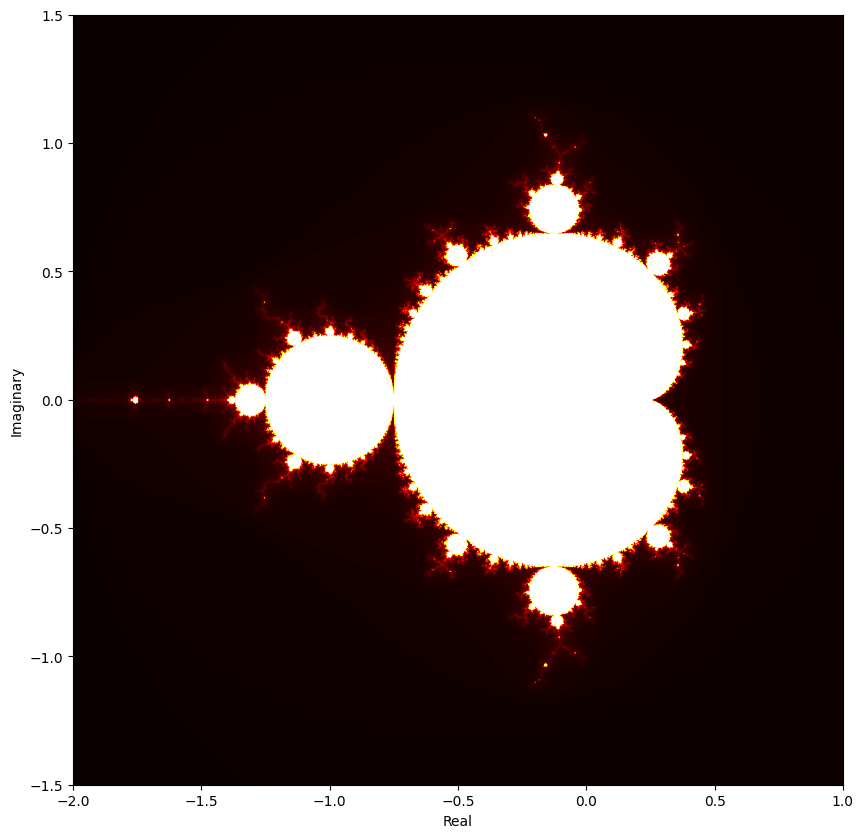

In [5]:
# Visualize with interpolation
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap='hot', interpolation='bilinear', extent=[-2, 1, -1.5, 1.5])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()

In [6]:
def custom_colourmap():
    #set up the control points for your gradient
    yR_observed = [0, 0,32,237, 255, 0, 0, 32]
    yG_observed = [2, 7, 107, 255, 170, 2, 7, 107]
    yB_observed = [0, 100, 203, 255, 0, 0, 100, 203]

    x_observed = [-.1425, 0, .16, .42, .6425, .8575, 1, 1.16]

    #Create the arrays with the interpolated values
    x = np.linspace(min(x_observed), max(x_observed), num=1000)
    yR = pchip_interpolate(x_observed, yR_observed, x)
    yG = pchip_interpolate(x_observed, yG_observed, x)
    yB = pchip_interpolate(x_observed, yB_observed, x)

    #Convert them back to python lists
    x = list(x)
    yR = list(yR)
    yG = list(yG)
    yB = list(yB)

    #Find the indexs where x crosses 0 and crosses 1 for slicing
    start = 0
    end = 0
    for i in x:
        if i > 0:
            start = x.index(i)
            break

    for i in x:
        if i > 1:
            end = x.index(i)
            break

    #Slice away the helper data in the begining and end leaving just 0 to 1
    x = x[start:end]
    yR = yR[start:end]
    yG = yG[start:end]
    yB = yB[start:end]

    # Normalize the color values to the [0, 1] range
    yR = np.array(yR) / 255.0
    yG = np.array(yG) / 255.0
    yB = np.array(yB) / 255.0

    # Append 0 to the end of yR, yG, and yB
    yR = np.append(yR, 0.0)
    yG = np.append(yG, 0.0)
    yB = np.append(yB, 0.0)

    # Create a custom colormap from the interpolated color values
    colors = np.column_stack((yR, yG, yB))  # Combine R, G, and B values
    cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
    
    return cmap


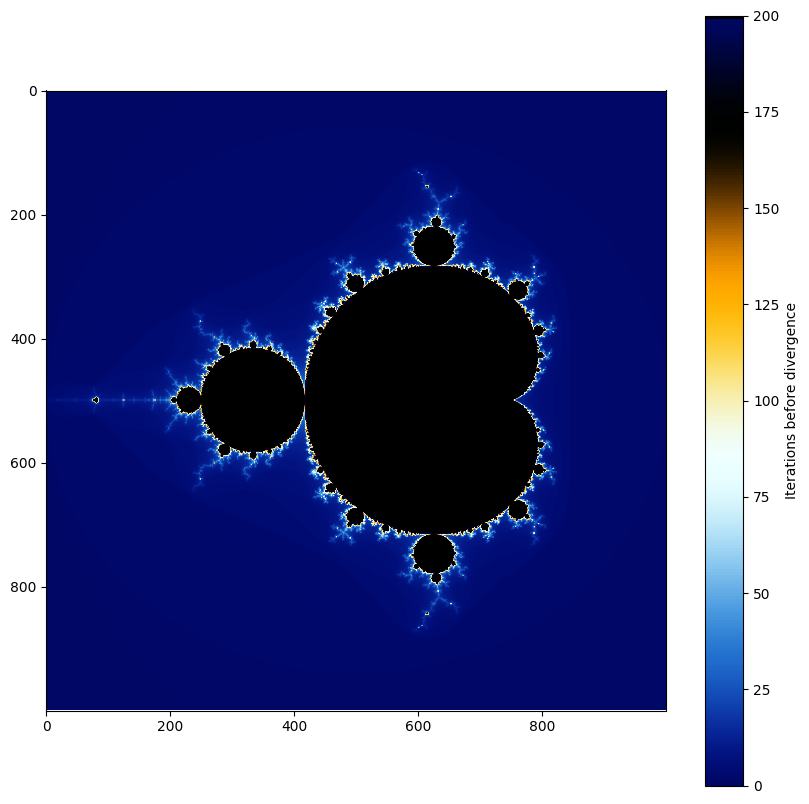

In [7]:
cmap = custom_colourmap()

# Create a figure and plot the data using the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap=cmap)
plt.colorbar().set_label('Iterations before divergence')
plt.show()

In [8]:
# Seahorse valley
resolution = 1000
max_iter = 200
width = resolution
height = resolution
real_range = [-0.75, -0.74]
imag_range = [0.1, 0.11]
seahorse_valley = mandelbrot_set(width, height, real_range, imag_range, max_iter=max_iter)

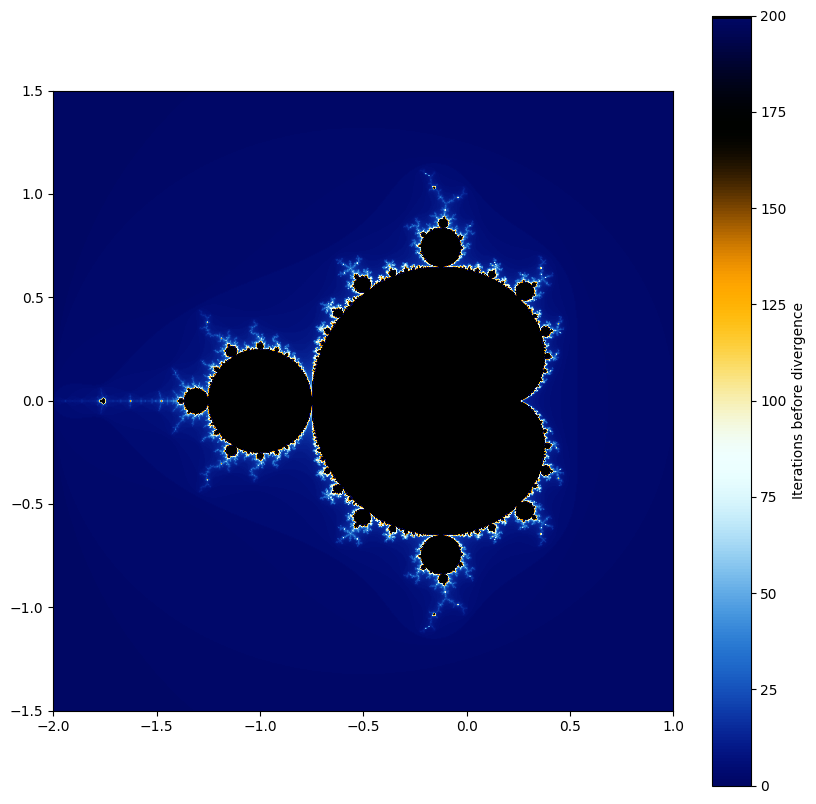

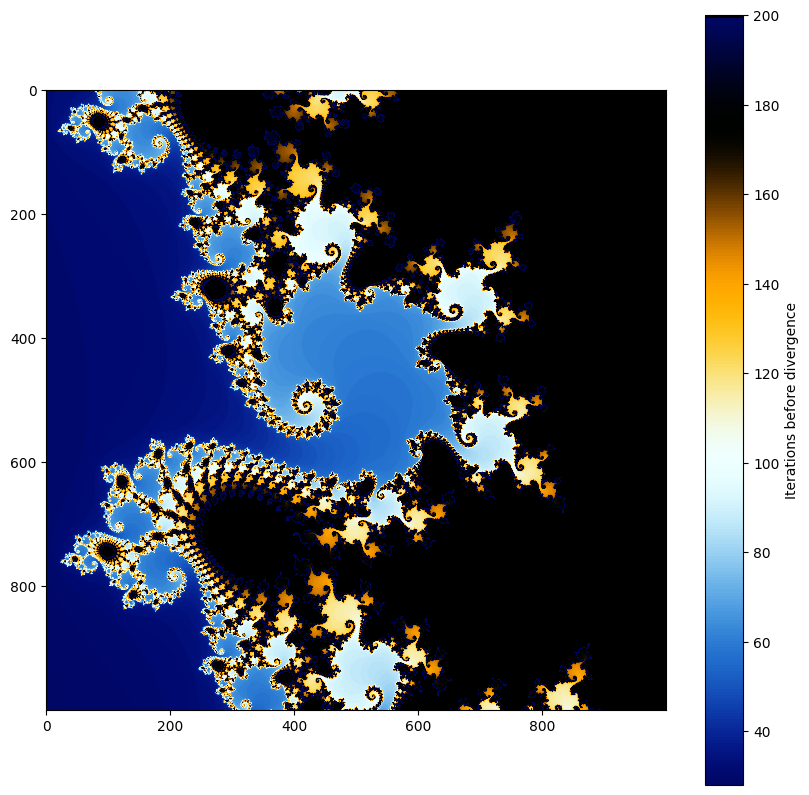

In [9]:
# First plot the Mandelbrot set with a box around the seahorse valley
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap=cmap, extent=[-2, 1, -1.5, 1.5])
plt.colorbar().set_label('Iterations before divergence')
plt.show()

# Plot seahorse valley
plt.figure(figsize=(10, 10))
plt.imshow(seahorse_valley.T, cmap=cmap)
plt.colorbar().set_label('Iterations before divergence')
plt.show()

### Mandelbrot Set Computation

In [12]:
def random_sampling(s, x_range = [-2, 1], y_range = [-1.5, 1.5]):
    x_samples = np.random.uniform(low=x_range[0], high=x_range[1], size=s)
    y_samples = np.random.uniform(low=y_range[0], high=y_range[1], size=s)
    samples = np.column_stack((x_samples, y_samples))
    return samples

def latin_hypercube_sampling(s, x_range = [-2, 1], y_range = [-1.5, 1.5], strength = 1, numpy_random_generator = np.random.Generator(np.random.PCG64())):
    sampler = qmc.LatinHypercube(d=2, strength=strength, seed=numpy_random_generator)
    sample = sampler.random(n=s)
    l_bounds = np.array([x_range[0], y_range[0]])
    u_bounds = np.array([x_range[1], y_range[1]])
    sample = qmc.scale(sample, l_bounds, u_bounds)
    return sample

def orthogonal_sampling(s, x_range = [-2, 1], y_range = [-1.5, 1.5], numpy_random_generator = np.random.Generator(np.random.PCG64())):
    return latin_hypercube_sampling(s, x_range, y_range, strength = 2, numpy_random_generator=numpy_random_generator)

def approximation(samples, i, visualize_sample = False, x_range = [-2, 1], y_range = [-1.5, 1.5]):
    # Approximate the area of the mandelbrot set. samples is a list of samples, i is the number of iterations for the mandelbrot calculation
    
    # Compute the area of the mandelbrot set
    area = 0
    for sample in samples:
        if stability(sample[0] + 1j*sample[1], max_iter=i) == i:
            area += 1

    #plot samples to visualize
    if visualize_sample:
        in_area = []
        out_area = []
        for sample in samples:
            if stability(sample[0] + 1j*sample[1], max_iter=max_iter) == max_iter:
                in_area.append(sample)
            else:
                out_area.append(sample)

        # Plot the sample over our mandelbrot set
        plt.figure(figsize=(10, 10))
        plt.imshow(image.T, cmap=cmap, interpolation='bilinear', extent=[-2, 1, -1.5, 1.5])
        # plt.scatter(samples[:, 0], samples[:, 1], color='red', s=0.6)
        # in_area green, out_area red
        plt.scatter(np.array(in_area)[:, 0], np.array(in_area)[:, 1], color='green', s=0.6)
        plt.scatter(np.array(out_area)[:, 0], np.array(out_area)[:, 1], color='red', s=0.6)
        plt.show()
    
    
    # Scale the area to the size of the mandelbrot set
    area = area / len(samples) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    
    return area

In [ ]:
# Test if I can use the numpy random generator
generator = np.random.Generator(np.random.PCG64(seed=4444))

print(latin_hypercube_sampling(4, numpy_random_generator=generator))

generator = np.random.Generator(np.random.PCG64(seed=4444))

print(latin_hypercube_sampling(4, numpy_random_generator=generator))

print(latin_hypercube_sampling(4, numpy_random_generator=generator))


[[ 0.25705496 -0.55226063]
 [-1.50133642  1.22169109]
 [-0.01522048 -1.38626516]
 [-0.65565678  0.49768446]]
[[ 0.25705496 -0.55226063]
 [-1.50133642  1.22169109]
 [-0.01522048 -1.38626516]
 [-0.65565678  0.49768446]]
[[ 0.47673915 -0.54965559]
 [-1.74812439  0.5379105 ]
 [ 0.14053589 -0.99450401]
 [-0.85299634  0.86692645]]


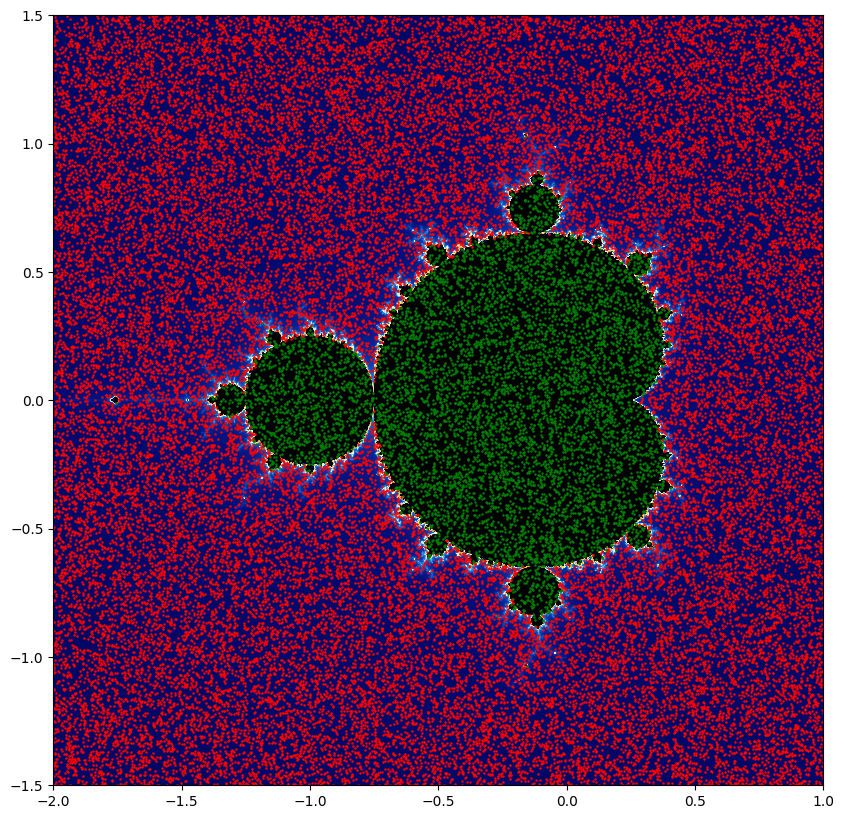

Area using random_sampling: 1.5452150656558545


In [ ]:
visualize = True
for sampling_method in [random_sampling]:
    sample = sampling_method(223**2)
    area = approximation(sample, 200, visualize_sample = visualize)
    print(f'Area using {sampling_method.__name__}: {area}')

In [14]:
# Highest possible approximation random sampling
s = 10**6
i = 10000
start = time.time()
sample = random_sampling(s)
sampling_time = time.time() - start
area = approximation(sample, i)
approximation_time = time.time() - start - sampling_time
print(f"Area for {s} samples and {i} iterations: {area} (sampling time: {sampling_time}s, approximation time: {approximation_time}s)")

Area for 1000000 samples and 10000 iterations: 1.5062130000000002 (sampling time: 0.017176151275634766s, approximation time: 373.4053063392639s)


In [15]:
# Highest possible approximation latin hypercube sampling
s = 10**6
i = 10000
start = time.time()
sample = latin_hypercube_sampling(s)
sampling_time = time.time() - start
area = approximation(sample, i)
approximation_time = time.time() - start - sampling_time
print(f"Area for {s} samples and {i} iterations: {area} (sampling time: {sampling_time}s, approximation time: {approximation_time}s)")

Area for 1000000 samples and 10000 iterations: 1.5009569999999999 (sampling time: 0.08265471458435059s, approximation time: 393.96446561813354s)


In [16]:
# Highest possible approximation orthogonal sampling
s = 1009**2
i = 10000
start = time.time()
sample = latin_hypercube_sampling(s)
sampling_time = time.time() - start
area = approximation(sample, i)
approximation_time = time.time() - start - sampling_time
print(f"Area for {s} samples and {i} iterations: {area} (sampling time: {sampling_time}s, approximation time: {approximation_time}s)")

Area for 1018081 samples and 10000 iterations: 1.506858491613143 (sampling time: 0.07288813591003418s, approximation time: 377.6663599014282s)


In [90]:
# s = 31**2
s = 1000000
i = 10000
d = 0.0005

mean_areas = []
std_areas = []
i_values = []

np.random.seed(4444)

samples = random_sampling(s) # Generate i sample sets for the initial i
while True:
    area = approximation(samples, i)

    mean = statistics.mean(areas)
    std = statistics.stdev(areas) / np.sqrt(len(areas))
    i_values.append(i)
    print(f"At i: {i}, std: {std}")

    mean_areas.append(mean)
    std_areas.append(std)


    if std < d:
        print(f"Small enough standard deviation.")
        break
    
    i += 100

# Plot the mean area and standard deviation both with their own y-axis
# Create the primary axis
fig, ax1 = plt.subplots()
ax1.plot(i_values, mean_areas, color='tab:blue')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Mean area', color='tab:blue')

# Create the secondary axis
ax2 = ax1.twinx()
ax2.plot(i_values, std_areas, color='tab:red')
ax2.set_ylabel('Standard deviation', color='tab:red')

plt.title(f'Mean Area and Standard Deviation of the Mandelbrot Set Approximation (sample size = {s})')
plt.show()

# plt.figure(figsize=(10, 10))
# plt.plot(i_values, areas_per_method[0], label='Random')
# plt.plot(i_values, areas_per_method[1], label='Latin hypercube')
# plt.plot(i_values, areas_per_method[2], label='Orthogonal')
# plt.xlabel('Number of iterations')
# plt.ylabel('Area')
# plt.title(f'Area of the Mandelbrot set (sample size = {s})')
# plt.legend()
# plt.show()

TypeError: approximation() missing 1 required positional argument: 'i'